## Explore Regional Properties

- Select a bounding box, and investigate some SST properties, comparing Stochastic Model Output (with chosen forcing) against CESM.


In [18]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import cmocean
from tqdm import tqdm
import xarray as xr

#%% Set Paths, Import Custom Modules
stormtrack = 0
if stormtrack == 0:
    projpath   = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
    datpath     = projpath + '01_Data/model_output/'
    rawpath     = projpath + '01_Data/model_input/'
    outpathdat  = datpath + '/proc/'
    figpath     = projpath + "02_Figures/20220121/"
   
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")
    sys.path.append("/Users/gliu/Downloads/06_School/06_Fall2021/12860/materials_2020/Assignment5/HW5/")

elif stormtrack == 1:
    datpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_output/"
    rawpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"
    outpathdat  = datpath + '/proc/'
    
    
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")

from amv import proc,viz
import scm
import tbx
import hw5_utils as cvd

import importlib
importlib.reload(viz)

proc.makedir(figpath)

/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/02_Figures/20220121/ was found!


In [19]:
# User Selections
"""
# fnames: forcing id name (used to load the file)


# modids: list of indices of sm model runs to grab for each forcing
    0 (nonentrain, h-const) ... 
    1 (nonentrain, h-vary)  ... 
    2 (entrain, h-vary)
    
# enames : experiment name for each forcing and modid

"""

# Experiment 1 (Evaluating effect of spatial variation in MLD)
# ------------------------------------------------------------
exname = "hvary_space50m"
fnames = ('forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0',
          'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0_hfix50_slab'
         )#'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run009_ampq3',)
modids = ([0],
          [0],)
enames = ("h (Spatially Varying)",
          "h (50 meter)")

enames_short = ('hslab',
               'h50m')



In [21]:
# Experiment 2 (Evaluating effect of spatial variation in MLD with Qek)
# ------------------------------------------------------------
exname = "qek_spatial"
fnames = ('forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0_hfix50_slab',
          'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0',
          'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0_hfix50_slab_qek',
          'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0_hslab_slab_qek'
         )#'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run009_ampq3',)
modids = ([0],
          [0],
          [0],
          [0]
          )
enames = ("h (50m)",
          "h (Slab)",
          "h (50m + $Q_{ek}$)",
          "h (Slab + $Q_{ek}$)"
          )

enames_short = ('h50m',
                'hslab',
                'h50m-qek',
                'hslab-qek'
               )

# Load Stochastic Model Experiments

In [22]:
%%time

print("Loading Stochastic Model data for experiment: %s" % (exname))

nruns       = 0
sst_sm      = [] # [forcing/hconfig][lon x lat x time]
nforcings   = len(fnames)
for f in range(nforcings):
    
    # Load data
    fname = fnames[f] 
    ld   = np.load(datpath+"stoch_output_%s.npz"%(fname),allow_pickle=True)
    sst  = ld["sst"] #[modid][lon x lat x time]
    lonr = ld['lon']
    latr = ld['lat']
    
    # Only keep selected model configurations
    nmodels  = len(modids[f])
    for m in range(nmodels):
        im = modids[f][m] # Select Model
        sst_sm.append(sst[im])
        print("Loaded SST of size %s for %s"%(str(sst_sm[nruns].shape),enames[nruns]))
        nruns += 1

Loading Stochastic Model data for experiment: qek_spatial
Loaded SST of size (65, 69, 12000) for h (50m)
Loaded SST of size (65, 69, 12000) for h (Slab)
Loaded SST of size (65, 69, 12000) for h (50m + $Q_{ek}$)
Loaded SST of size (65, 69, 12000) for h (Slab + $Q_{ek}$)
CPU times: user 2.61 s, sys: 879 ms, total: 3.49 s
Wall time: 3.52 s


/Users/gliu/opt/anaconda3/envs/cvd-12860/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(<matplotlib.collections.QuadMesh at 0x7fd93903c690>,
 <matplotlib.colorbar.Colorbar at 0x7fd918f54cd0>)

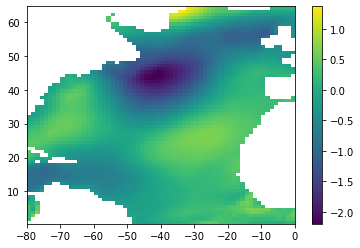

In [160]:
# Quick test plot
plt.pcolormesh(lonr,latr,sst_sm[0][:,:,2].T),plt.colorbar()

## Load CESM1

In [23]:
# Set CESM Parameters

# Additionally Load the CESM1-Data
mconfigs = ("SLAB","FULL")
cdatpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/"
bbox     = [np.floor(lonr[0]),np.ceil(lonr[-1]),np.floor(latr[0]),np.ceil(latr[-1])]
print("Simulation bounding Box is %s "% (str(bbox)))

Simulation bounding Box is [-80.0, 0.0, 0.0, 65.0] 


In [24]:
%%time
sst_cesm = []
for mconfig in mconfigs:
    fname   = "%sCESM1_%s_postprocessed_NAtl.nc" % (cdatpath,mconfig)
    ds      = xr.open_dataset(fname)
    dsreg   = ds.sel(lon=slice(bbox[0],bbox[1]),lat=slice(bbox[2],bbox[3]))
    sst_cesm.append(dsreg.SST.values)

/Users/gliu/opt/anaconda3/envs/cvd-12860/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/gliu/opt/anaconda3/envs/cvd-12860/lib/python3.7/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CPU times: user 8.76 s, sys: 1.24 s, total: 10 s
Wall time: 10.2 s


/Users/gliu/opt/anaconda3/envs/cvd-12860/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


(<matplotlib.collections.QuadMesh at 0x7fd94966b0d0>,
 <matplotlib.colorbar.Colorbar at 0x7fd929b0ec50>)

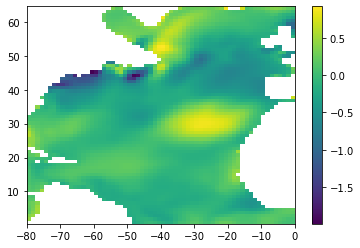

In [41]:
plt.pcolormesh(lonr,latr,sst_cesm[1][:,:,2].T),plt.colorbar()

## Variance Ratio Plots

### Ratio Between Stochastic Model Experiments

In [6]:
# Plotting Parameters
proj        = ccrs.PlateCarree()
bboxplot    = [-80,0,5,60]
cmax        = 2

Computing variance ratios relative to experiment: h (50 meter)


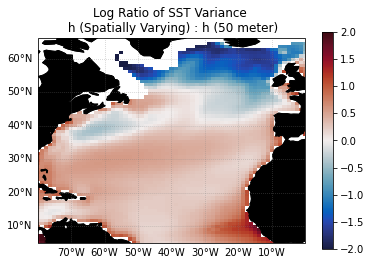

In [66]:
k = 0
print("Computing variance ratios relative to experiment: %s" % (enames[targid]))
numer     = sst_sm[k]
numername = enames[k]
for i,denomname in enumerate(enames):
    if denomname == numername:
        continue # Skip the given layer
    
    denom     = sst_sm[i]
    var_ratio = np.log(np.var(numer,2)/np.var(denom,2))
    
    fig,ax = plt.subplots(1,1,subplot_kw = {'projection':proj})
    
    ax = viz.add_coast_grid(ax=ax,bbox=bboxplot,fill_color='k')
    title = "Log Ratio of SST Variance \n %s : %s" % (numername,denomname)
    ax.set_title(title)
    pcm = ax.pcolormesh(lonr,latr,var_ratio.T,
                        vmin=-cmax,vmax=cmax,cmap='cmo.balance')
    
    fig.colorbar(pcm,ax=ax)
    
    plt.savefig("%s%s_logvratio_%s-to-%s.png"%(figpath,exname,enames_short[k],enames_short[i]),
                dpi=150,bbox_inches='tight')
    

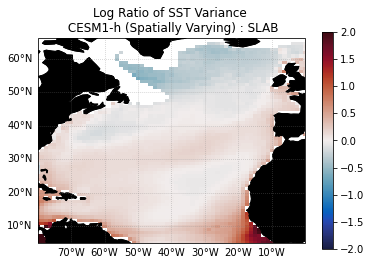

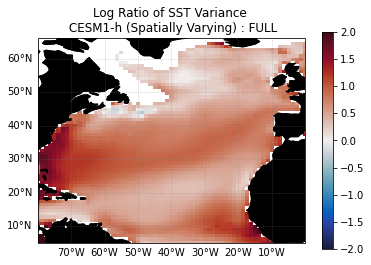

In [67]:
# Do the same, but now relative to CESM

for i,denomname in enumerate(mconfigs):
    if denomname == numername:
        continue # Skip the given layer
    
    denom     = sst_cesm[i]
    var_ratio = np.log(np.var(numer,2)/np.var(denom,2))
    
    fig,ax = plt.subplots(1,1,subplot_kw = {'projection':proj})
    
    ax = viz.add_coast_grid(ax=ax,bbox=bboxplot,fill_color='k')
    title = "Log Ratio of SST Variance \n CESM1-%s : %s" % (numername,denomname)
    ax.set_title(title)
    pcm = ax.pcolormesh(lonr,latr,var_ratio.T,
                        vmin=-cmax,vmax=cmax,cmap='cmo.balance')
    
    fig.colorbar(pcm,ax=ax)
    
    plt.savefig("%s%s_logvratio_%s-to-%s.png"%(figpath,exname,enames_short[k],mconfigs[i]),
                dpi=150,bbox_inches='tight')
    

# Examine effect of low-pass filter on a single experiment

In [70]:
# Try Lowpass Filter
ssttest = sst_sm[0].copy()
fny    = 1
cutoff = 120
fit    = 'low'

_,sst_lp=cvd.filtfilt_filter(ssttest,fny,cutoff,fit,order=6,axis=2)


In [71]:
sst_lp.shape

(65, 69, 12000)

In [80]:
# For a given SST, plot the effect of low pass filtering on pointwise variance

# Select SST
sstin   = sst_cesm[1]
sstname = mconfigs[1]

# LP Filter Options
fny    = 1
cutoff = 120
fit    = 'low'

# Calculate variance and lp-filtered variance
sstvar    = np.var(sstin,2)
_,sst_lp  = cvd.filtfilt_filter(sstin,fny,cutoff,fit,order=6,axis=2)
sstvar_lp = np.var(sst_lp,2)

# Set up for plotting
plotvars  = [sstvar,sstvar_lp,np.log(sstvar_lp/sstvar)]
plotnames = ["Variance","10-year LP Filtered Variance","Log Ratio (LP-Filtered/Unfiltered)"]
    
# title = "Log Ratio of SST Variance \n CESM1-%s : %s" % (numername,denomname)
# ax.set_title(title)
# pcm = ax.pcolormesh(lonr,latr,var_ratio.T,
#                     vmin=-cmax,vmax=cmax,cmap='cmo.balance')

# fig.colorbar(pcm,ax=ax)

# plt.savefig("%s%s_logvratio_%s-to-%s.png"%(figpath,exname,enames_short[k],mconfigs[i]),
#             dpi=150,bbox_inches='tight')




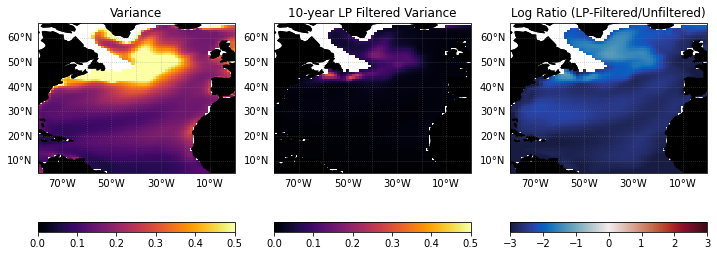

In [94]:
fig,axs  = plt.subplots(1,3,subplot_kw = {'projection':proj},figsize=(12,6))
for i in range(3):
    ax = axs.flatten()[i]
    ax = viz.add_coast_grid(ax=ax,bbox=bboxplot,fill_color='k')
    
    if i == 2:
        pcm = ax.pcolormesh(lonr,latr,plotvars[i].T,vmin=-3,vmax=3,cmap='cmo.balance')
    else:
        pcm = ax.pcolormesh(lonr,latr,plotvars[i].T,vmin=0,vmax=.5,cmap='inferno')
    
    fig.colorbar(pcm,ax=ax,orientation='horizontal')
    #pcm = ax.pcolormesh(lonr,latr,plotvars[0])
    
    ax.set_title(plotnames[i])

## Compare LP Filtered SLAB vs FULL (similar to Casey's Paper)

In [99]:
%%time
fny    = 1
cutoff = 60
fit    = 'low'

# Calculate normal and low-pass filtered variance
sstvars,sstvars_lp = [],[]
for i in range(2):
    sstvars.append(np.var(sst_cesm[i],2)) # Calculate variance
    _,sst_lp = cvd.filtfilt_filter(sst_cesm[i],fny,cutoff,fit,order=6,axis=2)
    sstvars_lp.append(np.var(sst_lp,2))

CPU times: user 3.7 s, sys: 984 ms, total: 4.68 s
Wall time: 4.69 s


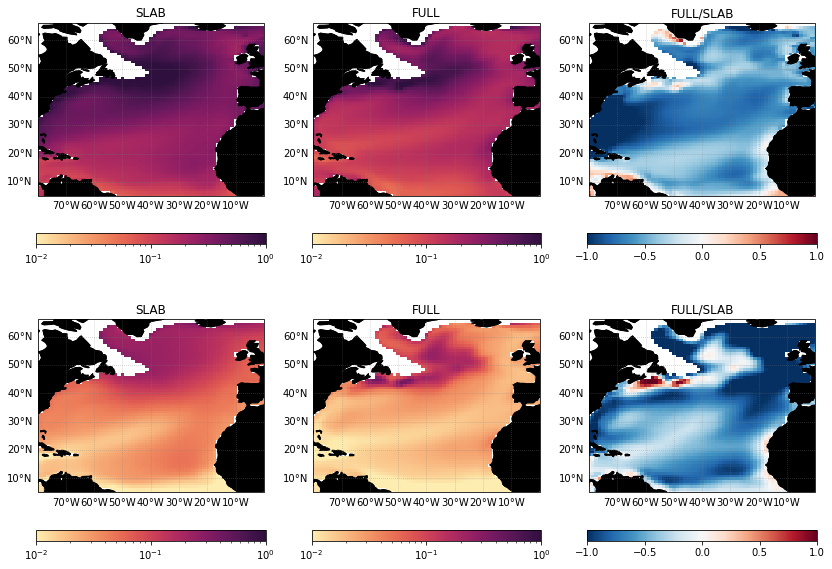

In [108]:

# Set up for plotting
import matplotlib.colors as colors
plotnames = ["Variance","10-year LP Filtered Variance","Log Ratio (LP-Filtered/Unfiltered)"]

fig,axs  = plt.subplots(2,3,subplot_kw = {'projection':proj},figsize=(14,10))
for row in range(2):
    if row == 0: # Normal
        varin = sstvars
    else:
        varin = sstvars_lp
    plotvars  = [varin[0],varin[1],np.log(varin[1]/varin[0])] 
    plotnames = ["SLAB","FULL","FULL/SLAB"]  
    for i in range(3):

        ax = axs[row,i]
        ax = viz.add_coast_grid(ax=ax,bbox=bboxplot,fill_color='k')
        
        if i == 2:
            pcm = ax.pcolormesh(lonr,latr,plotvars[i].T,vmin=-1,vmax=1,cmap='RdBu_r')
        else:
            pcm = ax.pcolormesh(lonr,latr,plotvars[i].T,cmap='cmo.matter',
                                norm=colors.LogNorm(vmin=0.01, vmax=1))
    
        fig.colorbar(pcm,ax=ax,orientation='horizontal')
        #pcm = ax.pcolormesh(lonr,latr,plotvars[0])
        ax.set_title(plotnames[i])
plt.savefig("%sCESM_FULL-SLAB_vratios_lpfilter.png"% (figpath),dpi=150,bbox_inches='tight')

## Regional Analysis


<GeoAxesSubplot:>

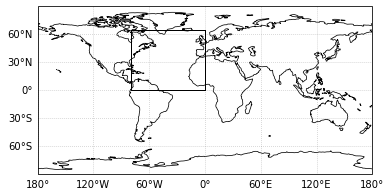

In [25]:
bbox_sel = [-80,0,0,65]

fig,ax    = plt.subplots(1,1,subplot_kw = {'projection':proj})
ax        = viz.add_coast_grid(ax=ax)
viz.plot_box(bbox_sel,ax=ax)

In [26]:
%%time
# Take a regional average of the input SSTs

#
if exname == "hvary_space50m":
    inssts   = [sst_sm[0],sst_sm[1],sst_cesm[0],sst_cesm[1]]
    inlabels = np.hstack([enames,mconfigs])
    incols   = ["red","purple","gray","k"]
    nsmooths = [100,100,100,100]
elif exname == "qek_spatial":
    inssts   = sst_sm+sst_cesm#np.hstack([sst_sm,sst_cesm])
    inlabels = np.hstack([enames,mconfigs])
    incols   = ["darkblue","red","cornflowerblue","lightsalmon","gray","k"]    
    nsmooths = np.ones(len(inssts))*100

print(inlabels)
print(len(inssts))

['h (50m)' 'h (Slab)' 'h (50m + $Q_{ek}$)' 'h (Slab + $Q_{ek}$)' 'SLAB'
 'FULL']
6
CPU times: user 807 µs, sys: 99.6 ms, total: 100 ms
Wall time: 100 ms


In [27]:
%%time
regavg   = []
for n in range(len(inssts)):
    sstout = proc.sel_region(inssts[n],lonr,latr,bbox_sel,reg_avg=1,awgt=1)
    regavg.append(sstout)

CPU times: user 3.17 s, sys: 1.67 s, total: 4.84 s
Wall time: 4.85 s


In [29]:
%%time
# Perform spectral analysis

# From SM Stylesheet
xlm = [1e-2,5e0]
xper = np.array([100,50,20,10,5,2])
xtks = 1/xper
xlm  = [xtks[0],xtks[-1]]

dt      = 3600*24*365
dts     = np.ones(len(inssts))*dt



specs,freqs,CCs,dofs,r1s = scm.quick_spectrum(regavg,nsmooths,0.10,dt=dts)



CPU times: user 757 ms, sys: 97.8 ms, total: 854 ms
Wall time: 62 ms


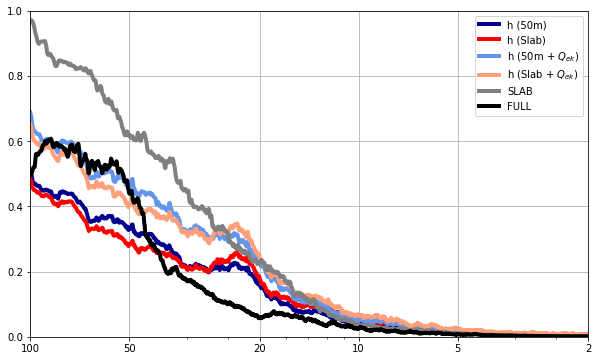

In [33]:

fig,ax = plt.subplots(1,1,figsize=(10,6))

for n in range(len(inssts)):
    
    
    ax.semilogx(freqs[n]*dt,specs[n]/dt,color=incols[n],label=inlabels[n],lw=4)
    
ax.set_xticks(xtks)
ax.set_xticklabels(xper)
ax.set_xlim([1/100,1/2])
ax.set_ylim([0,1])
#ax.set_xlim([1/50,1/5])
ax.legend()
ax.grid(True)

In [22]:
# Visualize the variance
sstvar = np.var(sst_sm[0],axis=2)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

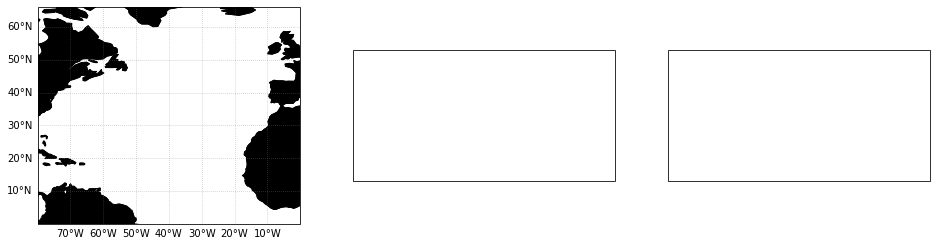

In [23]:
bbox   = [-80,0,0,60] 
fig,axs = viz.init_fig(1,3,figsize=(16,6))

vmin = 0
vmax = 5
for imod in range(3):
    ax = axs.flatten()[imod]
    ax=viz.add_coast_grid(ax,bbox=bbox,fill_color="k")
    pcm = ax.pcolormesh(lonr,latr,sstvar[imod,:,:].T,
                        vmin=vmin,vmax=vmax,cmap='jet')
    ax.set_title(model[imod])
cb = fig.colorbar(pcm,ax=axs.flatten(),fraction=0.046,orientation='horizontal')
cb.set_label("SST Variance ($\degree C^2$)")

# Convert stochastic model output to an xarray dataset/netCDF

In [33]:
# Convert stochastic model output to an xarray dataset
sstperm = sst.transpose(3,2,1,0) # [time x lat x lon x model]

In [38]:


times  = np.arange(0,sstperm.shape[0])
sstperm.shape



(12000, 69, 65, 3)

In [61]:
%%time
das = []
for i in range(3):
    da = proc.numpy_to_da(sstperm[...,i],times,latr,lonr,model[i]+"_sst")
    #print(da)
    das.append(da)
das[-1]

CPU times: user 1.17 ms, sys: 4 µs, total: 1.17 ms
Wall time: 1.18 ms


<xarray.DataArray 'entrain_sst' (time: 12000, lat: 69, lon: 65)>
array([[[            nan,             nan,             nan, ...,
          2.79000796e-01,  4.24679796e-01,             nan],
        [            nan,             nan,             nan, ...,
          1.87469574e-01,  1.51682546e-01,             nan],
        [ 3.17703206e+00,  6.07030097e+00,             nan, ...,
          1.80762032e-01,  1.33880194e-01,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          6.64153318e-02,  6.16562926e-02,  5.93496988e-02],
        [            nan,             nan,             nan, ...,
          9.13568101e-02,  8.28216214e-02,  7.43669175e-02],
        [            nan,             nan,             nan, ...,
          1.24673397e-01,  1.13432296e-01,  1.07812737e-01]],

       [[            nan,             nan,             nan, ...,
          5.22695331e-01,  7.68673630e-01,             nan],
        [            nan,             nan,             nan, ...,
          2.50418547e-01,  3.00502795e-01,             nan],
        [ 1.08304874e+00,  2.17844206e+00,             nan, ...,
          2.51011794e-01,  2.70216280e-01,             nan],
...
        [            nan,             nan,             nan, ...,
         -6.50264181e-01, -8.49730761e-01, -1.10177196e+00],
        [            nan,             nan,             nan, ...,
         -7.21536702e-01, -8.55010117e-01, -1.05806195e+00],
        [            nan,             nan,             nan, ...,
         -7.96385115e-01, -8.46302261e-01, -9.60330791e-01]],

       [[            nan,             nan,             nan, ...,
         -1.48114534e+00, -1.20736075e+00,             nan],
        [            nan,             nan,             nan, ...,
         -1.11324427e+00, -6.20265743e-01,             nan],
        [ 1.40343430e+00,  5.01731796e-01,             nan, ...,
         -1.18400990e+00, -9.90893659e-01,             nan],
        ...,
        [            nan,             nan,             nan, ...,
         -2.62329079e-01, -4.84269452e-01, -7.09800399e-01],
        [            nan,             nan,             nan, ...,
         -3.46894030e-01, -4.78347072e-01, -7.20648348e-01],
        [            nan,             nan,             nan, ...,
         -4.01664628e-01, -4.52759099e-01, -6.12886064e-01]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 11994 11995 11996 11997 11998 11999
  * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
  * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0

In [62]:
# Merge into dataset
ds = xr.merge(das)
ds

<xarray.Dataset>
Dimensions:         (time: 12000, lat: 69, lon: 65)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 ... 11995 11996 11997 11998 11999
  * lat             (lat) float64 0.4712 1.414 2.356 3.298 ... 62.67 63.61 64.55
  * lon             (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -2.5 -1.25 0.0
Data variables:
    h-constant_sst  (time, lat, lon) float64 nan nan nan ... 0.0905 0.004455
    h-vary_sst      (time, lat, lon) float64 nan nan nan ... -1.591 -1.582
    entrain_sst     (time, lat, lon) float64 nan nan nan ... -0.4528 -0.6129

In [67]:
edict = {vnames[i] + "_sst": {'zlib': True} for i in range(len(model))}
edict

{'h-constant_sst': {'zlib': True},
 'h-vary_sst': {'zlib': True},
 'entrain_sst': {'zlib': True}}

In [68]:
%%time
# Save Dataset
outname = "%sstoch_output_%s.nc" % (datpath,fname)
ds.to_netcdf(outname,
                 encoding=edict)
print(outname)


/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_output/stoch_output_forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0.nc
CPU times: user 28.6 s, sys: 508 ms, total: 29.1 s
Wall time: 29.3 s


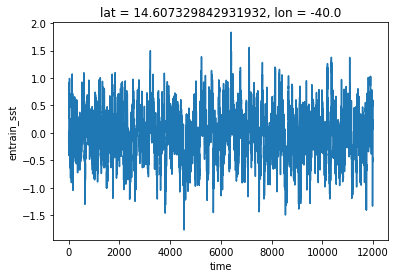

In [50]:
das[2].sel(lon=-40,lat=15,method='nearest').plot()

In [52]:
ds = xr.Dataset(das[0])

TypeError: unhashable type: 'DataArray'

In [53]:
vnames = model

In [54]:


coords = ["time", "lat", "lon"]
pairs  = [(coords,da[i]) for i in range(len(das))]


pairs
#vdict = { key:value for }

[(['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,        nan, ..., 0.2790008 , 0.4246798 ,
                 nan],
         [       nan,        nan,        nan, ..., 0.18746957, 0.15168255,
                 nan],
         [3.17703206, 6.07030097,        nan, ..., 0.18076203, 0.13388019,
                 nan],
         ...,
         [       nan,        nan,        nan, ..., 0.06641533, 0.06165629,
          0.0593497 ],
         [       nan,        nan,        nan, ..., 0.09135681, 0.08282162,
          0.07436692],
         [       nan,        nan,        nan, ..., 0.1246734 , 0.1134323 ,
          0.10781274]])
  Coordinates:
      time     int64 0
    * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
    * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0),
 (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,  

In [56]:
vdict = {vnames[i]:pairs[i] for i in range(len(das)) }
vdict

{'h-constant': (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,        nan, ..., 0.2790008 , 0.4246798 ,
                 nan],
         [       nan,        nan,        nan, ..., 0.18746957, 0.15168255,
                 nan],
         [3.17703206, 6.07030097,        nan, ..., 0.18076203, 0.13388019,
                 nan],
         ...,
         [       nan,        nan,        nan, ..., 0.06641533, 0.06165629,
          0.0593497 ],
         [       nan,        nan,        nan, ..., 0.09135681, 0.08282162,
          0.07436692],
         [       nan,        nan,        nan, ..., 0.1246734 , 0.1134323 ,
          0.10781274]])
  Coordinates:
      time     int64 0
    * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
    * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0),
 'h-vary': (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[ 

In [58]:
xr.Dataset(vdict)

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

In [59]:
hey = xr.merge(das)
hey

<xarray.Dataset>
Dimensions:         (time: 12000, lat: 69, lon: 65)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 ... 11995 11996 11997 11998 11999
  * lat             (lat) float64 0.4712 1.414 2.356 3.298 ... 62.67 63.61 64.55
  * lon             (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -2.5 -1.25 0.0
Data variables:
    h-constant_sst  (time, lat, lon) float64 nan nan nan ... 0.0905 0.004455
    h-vary_sst      (time, lat, lon) float64 nan nan nan ... -1.591 -1.582
    entrain_sst     (time, lat, lon) float64 nan nan nan ... -0.4528 -0.6129